# Определение возраста покупателей

**Описание проекта**

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
Контролировать добросовестность кассиров при продаже алкоголя.
Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

**Инструкция по выполнению проекта**

Проведите исследовательский анализ набора фотографий.
Подготовьте данные к обучению.
Обучите нейронную сеть и рассчитайте её качество.

## Исследовательский анализ данных

In [1]:
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import plotly
import plotly.graph_objs as go

sns.set()

Загрузил все необходимые библиотеки и прочитал датасет

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
#labels = pd.read_csv('labels.csv') 
labels

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17
...,...,...
7586,007608.jpg,14
7587,007609.jpg,37
7588,007610.jpg,28
7589,007611.jpg,20


In [3]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


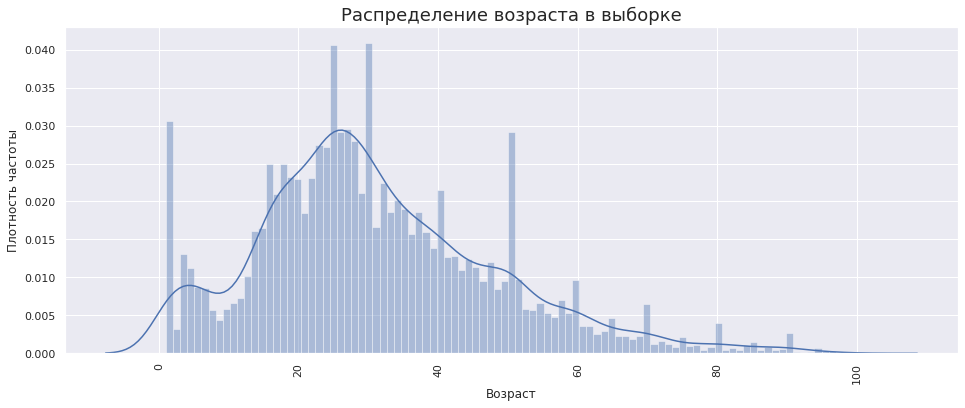

In [4]:
fig, ax = plt.subplots(figsize=(16, 6))
sns.distplot(labels['real_age'], bins=len(labels['real_age'].unique()))
ax.set_title('Распределение возраста в выборке', fontdict={'fontsize': 18})
plt.xticks(rotation=90)
plt.xlabel('Возраст', fontsize=12)
plt.ylabel('Плотность частоты', fontsize=12);

Построил график распределения возраста. Самые популярные возраста примерно от 20 до 40 лет, чтобы посмотреть подробнее, построю Boxplot. Есть выбросы, есть нулевые выборки, но что то с ними делать я так понимаю не стоит, задача проекта немного другая, поэтому построю сортировки по индексам и по годам, а также Boxplot этого распределения.

In [5]:
labels['real_age'].value_counts().sort_index()

1      149
2       88
3       25
4      101
5       87
      ... 
94       5
95       2
96       2
97       1
100      1
Name: real_age, Length: 97, dtype: int64

In [6]:
labels['real_age'].value_counts()

30     317
25     315
27     229
26     226
28     217
      ... 
96       2
93       1
100      1
91       1
97       1
Name: real_age, Length: 97, dtype: int64

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


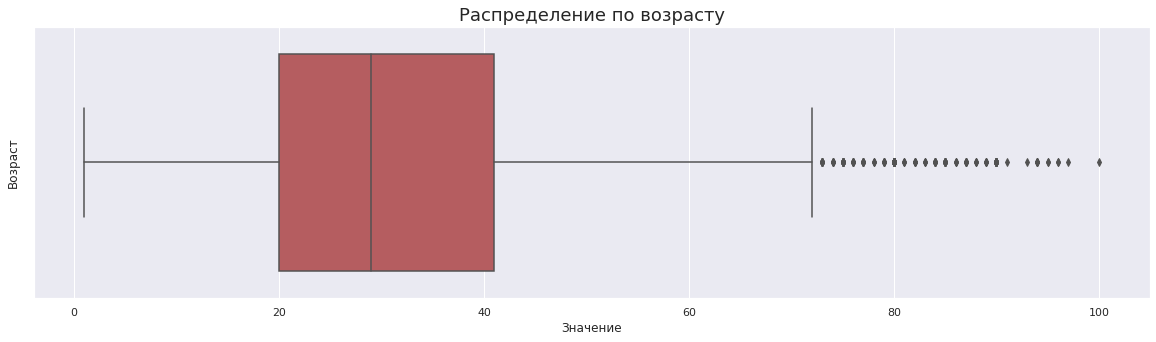

In [7]:
plt.figure(figsize=(20,5))
sns.boxplot(labels['real_age'], color='r').set(xlabel='Значение', ylabel='Возраст')                          
plt.title(label='Распределение по возрасту', fontdict={'fontsize': 18})
plt.show()

Выведу рандомное изобрадение

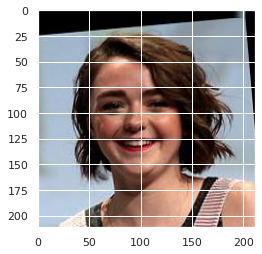

In [8]:
image = Image.open('/datasets/faces/final_files/' + labels.loc[4, 'file_name'])
array = np.array(image)
plt.imshow(array);

In [9]:
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(256, 256),
        batch_size=32,
        class_mode='raw',
        seed=17)

Found 7591 validated image filenames.


In [10]:
features, target = next(train_gen_flow)

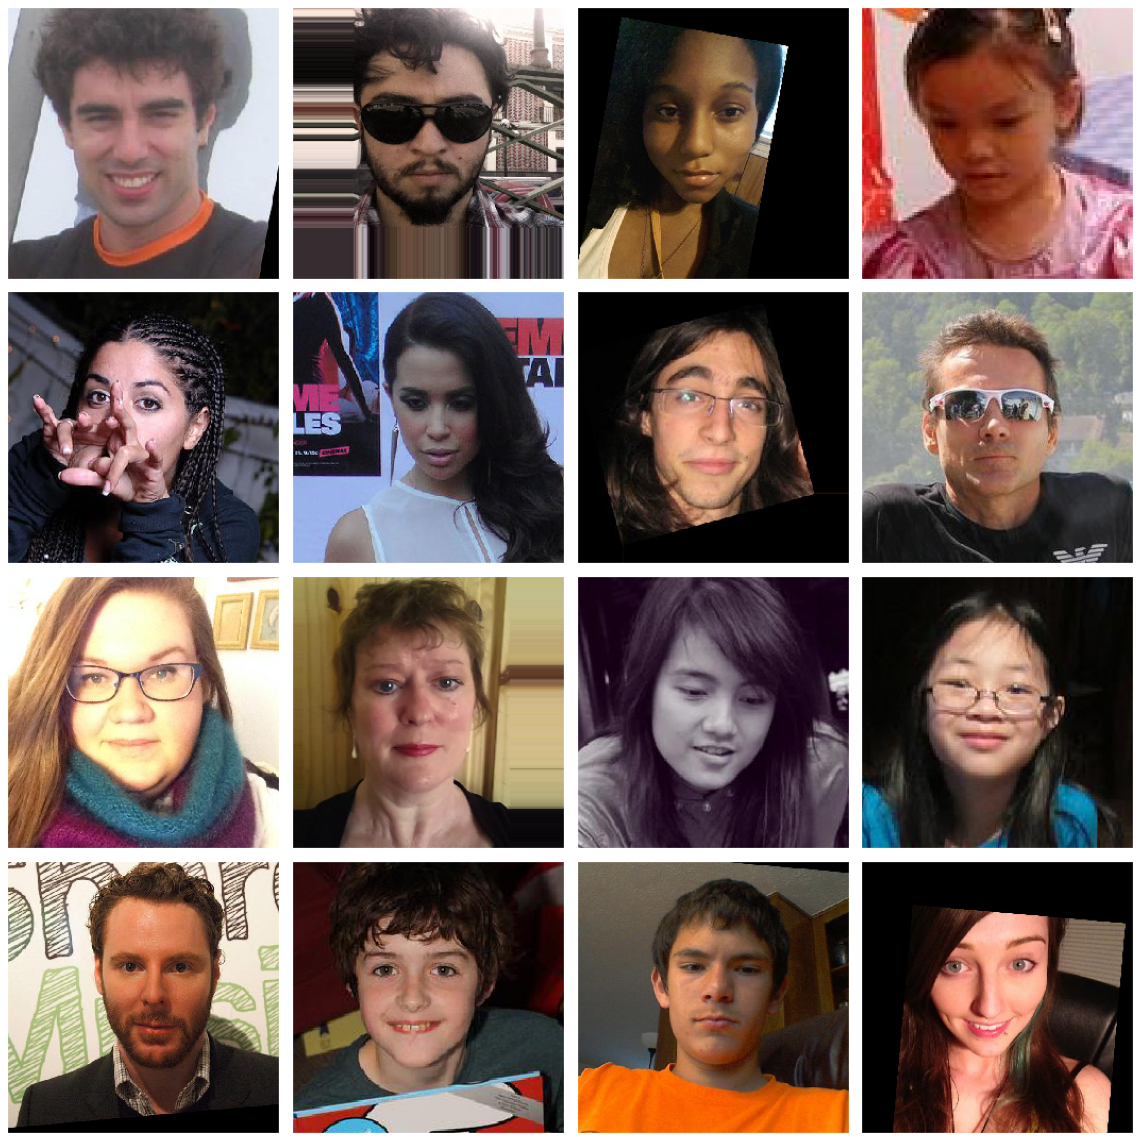

In [11]:
fig = plt.figure(figsize=(16,16))
for i in range(16):
    fig.add_subplot(4, 4, i + 1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

**Общий вывод:**
1. Изучены данные датафрейма.
2. Не на всех фото четкие лица, есть фото в очках, повернутые фото, черно-белые, в обработке, закрытые лица.
3. Распределение данных имеет вид бимодального распределения с длинных хвостом
4. Средний возраст на фотографиях от 20 до 40 лет.

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50


from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
import pandas as pd

def load_train(path):
    labels = pd.read_csv(path + 'labels.csv') 
    train_datagen = ImageDataGenerator(
        rescale=1./255, 
        vertical_flip=Falase, 
        validation_split=0.2)

    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(256, 256),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)
    return train_gen_flow


def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.2)

    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(256, 256),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)
    return test_gen_flow

def create_model(input_shape):
    optimizer = Adam(lr=0.0001)
    backbone = ResNet50(input_shape=input_shape, weights='imagenet', include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae'])
    return model

def train_model(model, train_gen_flow, test_gen_flow, batch_size=None, epochs=15, 
                steps_per_epoch=None, validation_steps=None):
    if steps_per_epoch is None:
        steps_per_epoch = len(train_gen_flow)
    if validation_steps is None:
        validation_steps = len(test_gen_flow)
    model.fit(train_gen_flow,
              validation_data=test_gen_flow,
              batch_size=batch_size, 
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, 
              shuffle=True)             
    return model
```

```

Train for 190 steps, validate for 48 steps
Epoch 1/15
2022-06-22 13:52:58.930172: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-06-22 13:52:59.242541: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
190/190 - 45s - loss: 254.6447 - mae: 11.5306 - val_loss: 503.0280 - val_mae: 17.2196
Epoch 2/15
190/190 - 37s - loss: 94.3014 - mae: 7.3606 - val_loss: 539.6695 - val_mae: 17.9991
Epoch 3/15
190/190 - 38s - loss: 63.9679 - mae: 6.0650 - val_loss: 232.4180 - val_mae: 11.6133
Epoch 4/15
190/190 - 38s - loss: 46.2145 - mae: 5.1335 - val_loss: 148.6494 - val_mae: 9.6665
Epoch 5/15
190/190 - 38s - loss: 34.7236 - mae: 4.4681 - val_loss: 89.6026 - val_mae: 7.3610
Epoch 6/15
190/190 - 37s - loss: 29.0364 - mae: 4.1172 - val_loss: 85.3843 - val_mae: 6.7802
Epoch 7/15
190/190 - 38s - loss: 22.3551 - mae: 3.6164 - val_loss: 67.4057 - val_mae: 6.2710
Epoch 8/15
190/190 - 38s - loss: 19.2736 - mae: 3.4050 - val_loss: 70.0959 - val_mae: 6.3864
Epoch 9/15
190/190 - 38s - loss: 16.7880 - mae: 3.1658 - val_loss: 72.5772 - val_mae: 6.5608
Epoch 10/15
190/190 - 37s - loss: 15.6308 - mae: 3.0789 - val_loss: 76.4056 - val_mae: 6.5402
Epoch 11/15
190/190 - 38s - loss: 14.4725 - mae: 2.9414 - val_loss: 66.5459 - val_mae: 6.1821
Epoch 12/15
190/190 - 38s - loss: 12.1023 - mae: 2.6796 - val_loss: 82.5017 - val_mae: 7.1261
Epoch 13/15
190/190 - 37s - loss: 11.9708 - mae: 2.6290 - val_loss: 76.6589 - val_mae: 6.7822
Epoch 14/15
190/190 - 38s - loss: 11.3597 - mae: 2.5666 - val_loss: 66.3634 - val_mae: 6.2012
Epoch 15/15
190/190 - 38s - loss: 10.9045 - mae: 2.4920 - val_loss: 71.0947 - val_mae: 6.3401
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
48/48 - 8s - loss: 71.0947 - mae: 6.4301
Test MAE: 6.3401

```

**Вывод раздела:**
1. Обучил свёрточную нейронную сеть с архитектурой ResNet50.
2. Получили метрику качества МАЕ - 6.43. Модель в среднем ошибается на это значение при прогнозе возраста.

## Анализ обученной модели

Данные распределены не равномерно, медиана находится на 30 годах, основная масса от 20 до 40 лет. Соответственно модель лучше всего обучится на среднем возрасте, а большие значения ошибки будут у старшего поколения.

## Общий вывод проекта

1. Обученная свёрточная нейронная сеть ResNet50 показала метрику качества 6.43, что соответствет требованиям задания.
2. Сетевой супермаркет «Хлеб-Соль» обзаведется системой компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы: Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;

## Чек-лист

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Исследовательский анализ данных выполнен
- [x]  Результаты исследовательского анализа данных перенесены в финальную тетрадь
- [x]  MAE модели не больше 8
- [x]  Код обучения модели скопирован в финальную тетрадь
- [x]  Результат вывода модели на экран перенесён в финальную тетрадь
- [x]  По итогам обучения модели сделаны выводы